# Assignment2 ZIJIN SU 22085664

## PART 1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba
from numba import cuda
import time
from scipy.sparse import coo_matrix
from scipy import sparse


In [2]:
def wave_sparse(N):
    """Computes a sparse matrix A and solution vector b for the time-harmonic wave problem (Ax=f)"""
    # create three lists to store inputs for constructing sparse matrix
    row = []
    columns = []
    data = []
    f = np.zeros(N+1)
    f[N]= 1
    h = 1/N
    k = (29*np.pi)/2
    # boudary condition
    for i in (0,N):
        row += [i]
        columns += [i]
        data += [1]
    # add value to exact position in the matrix          
    for i in range(1,N):
        row += [i,i,i] 
        columns += [i-1,i,i+1]
        data += [-1,2-(h**2)*(k**2),-1]
    
    row = np.array(row)
    columns = np.array(columns)
    data = np.array(data)
    
    A = coo_matrix((data, (row, columns)), shape=(N + 1, N + 1)).tocsr()
    return A,f

    

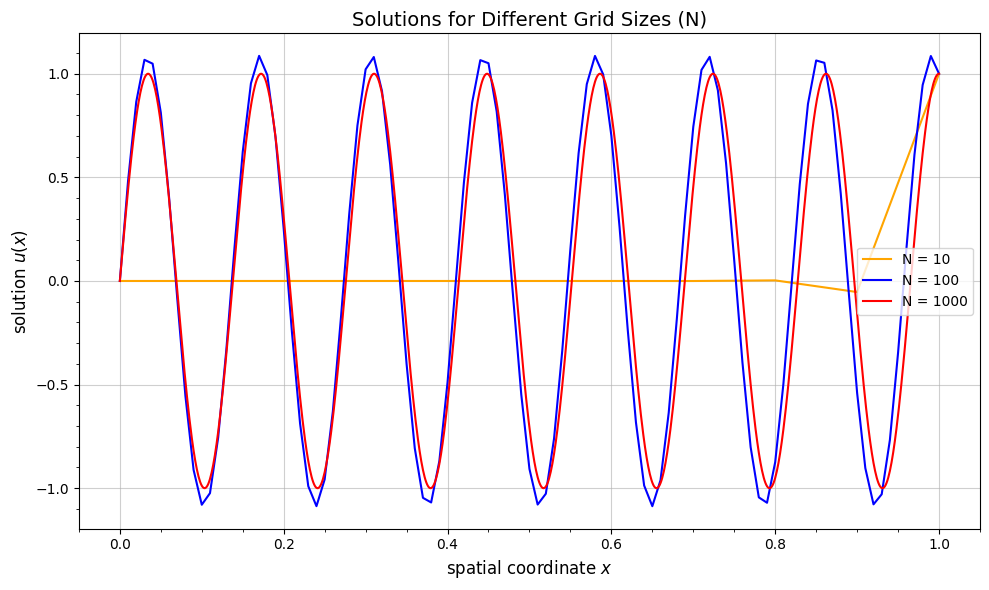

In [3]:
# solution with different N number and create empty list to store the answer
N = [10,100,1000]
A = []
f = []
sol = []
# using wave_sparse function for N values
for i in N:
    A_test,f_test = wave_sparse(i)
    A.append(A_test)
    f.append(f_test)

# Solving sparse matrix-vector problem using linalg functuion
for i in range(len(N)):
    sol_test = sparse.linalg.spsolve(A[i],f[i])
    sol.append(sol_test)

#visuliazing
plt.figure(figsize=(10, 6))
plt.title('Solutions for Different Grid Sizes (N)', fontsize=14)
plt.plot(np.linspace(0, 1, N[0]+1), sol[0], label='N = 10',color = 'orange')
plt.plot(np.linspace(0, 1, N[1]+1), sol[1], label='N = 100',color = 'blue')
plt.plot(np.linspace(0, 1, N[2]+1), sol[2], label='N = 1000',color='red')
plt.xlabel('spatial coordinate $x$', fontsize=12)
plt.ylabel('solution $u(x)$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.minorticks_on()
plt.grid(True, alpha=0.6)
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

The solutions differ because the value of $N$ determines the number of discrete grid points used in the system. As $N$ increases, the grid spacing $h = 1/N$ becomes smaller, moving the numerical approximation closer to the continuous limit where $h \to 0$. Consequently, the case with the largest $N$ (e.g., $N=1000$) yields the most accurate representation of the underlying function. This is evident from the smoother curve observed at higher $N$, which closely approximates the shape of a sine wave.


### Part1. second question: 
In this section, I will investigate the accuracy and computational efficiency of the numerical method developed above for solving the one-dimensional wave problem. Since the analytical solution $ u_{\text{exact}}(x) = \sin(kx) $ is known, I can directly quantify the numerical error and examine how it depends on the grid resolution $ N $. By comparing the computed solutions across different values of $\N$, I aim to assess the convergence behaviour of the method and explore the trade-off between accuracy and computational cost.


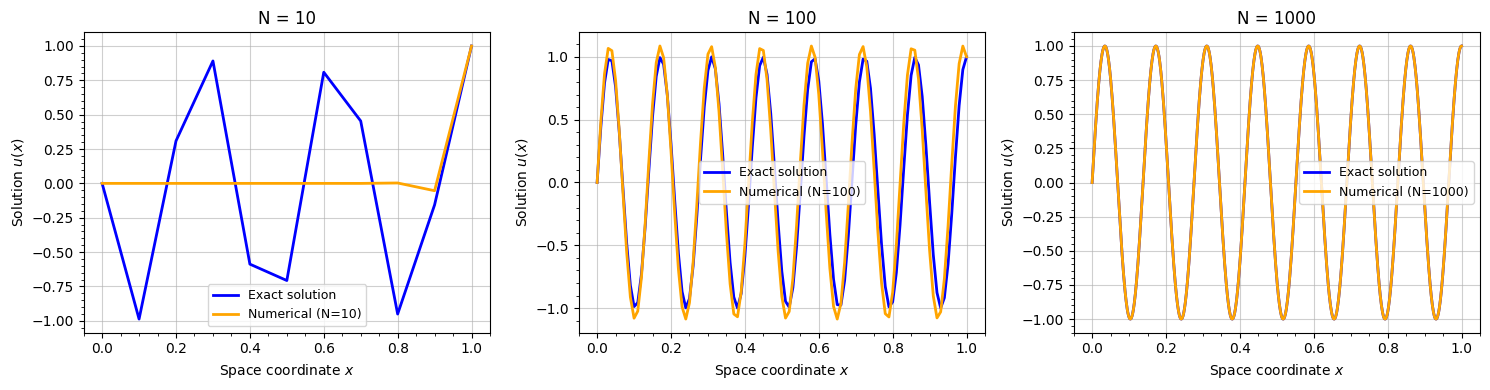

In [4]:
# Using exact solution
def u_exactvalue(x):
    """
    Compute exact solution u(x) = sin(kx) with k = 29π/2; 
    Input: x (float or array), 
    Output: u(x).
    """
    k = (29 * np.pi) / 2
    u_exact = np.sin(k * x)
    return u_exact

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = [f'N = {i}' for i in N]

# Comparing exact solution to wave_sparse function result
for i, ax in enumerate(axes):
    x = np.linspace(0, 1, N[i] + 1)
    ax.plot(x, u_exactvalue(x), color='blue', linewidth=2, label='Exact solution')
    ax.plot(x, sol[i], color='orange', linewidth=2, label=f'Numerical (N={N[i]})')
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel('Space coordinate $x$', fontsize=10)
    ax.set_ylabel('Solution $u(x)$', fontsize=10)
    ax.minorticks_on()
    ax.grid(True, alpha=0.6)
    ax.legend(fontsize=9, loc='best')


plt.tight_layout()
plt.show()

As clearly seen, when N=1000, two solution are alomost identical due to the small spacing $h=1/N$ 

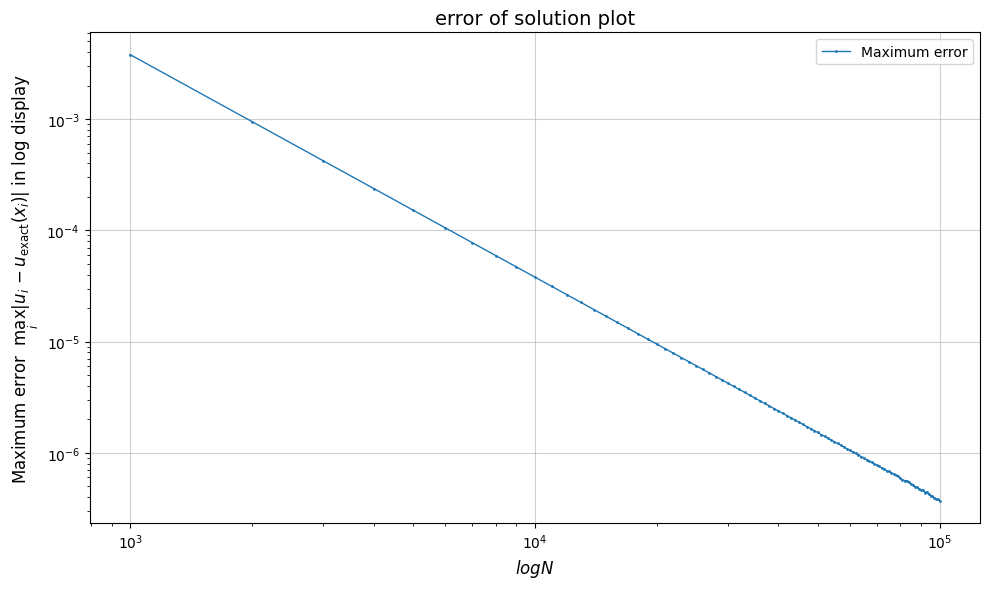

In [5]:
# new test, store new value and errors in new list 
u_x =[]
error = []
N_new = np.arange(1000,101000,1000) # big N for
k = (29*np.pi)/2

# Calling wave_sparse function for different N values
for i in N_new:
    A, f = wave_sparse(i)
    u_x.append(sparse.linalg.spsolve(A,f))
# Determining the error between exact solution and wave_sparse function
for i in u_x:
    error.append(np.max(abs(i - np.sin(k*np.linspace(0,1,len(i))))))
    
#visualizing
plt.figure(figsize=(10, 6))
plt.plot(N_new, error, marker='o',markersize=1, linewidth=1, label='Maximum error')
plt.title('error of solution plot', fontsize=14)
plt.xlabel('$logN$', fontsize=12)
plt.ylabel('Maximum error  $\\max_i |u_i - u_{\\mathrm{exact}}(x_i)|$ in log display' , fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True,  alpha=0.6)
plt.legend(fontsize=10, loc='best')
plt.tight_layout()

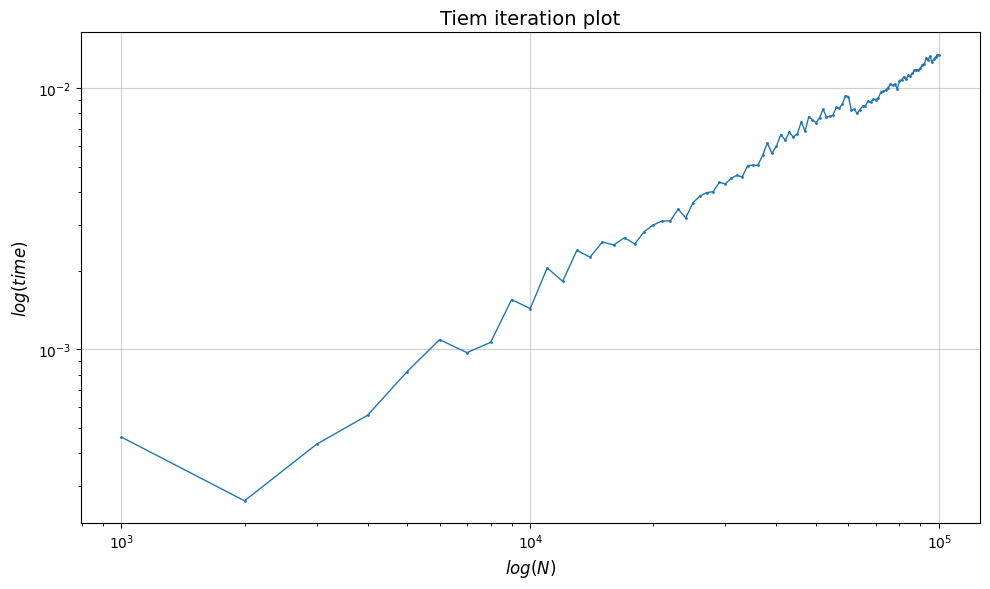

In [6]:
times = []
for i in N_new:
    A,f = wave_sparse(i)
    t = %timeit -o -q -r1 -n1 sol = sparse.linalg.spsolve(A,f)
    times.append(t.average)

#visualizing
plt.figure(figsize=(10, 6))
plt.plot(N_new, times, marker='o',markersize=1, linewidth=1)
plt.title('Tiem iteration plot', fontsize=14)
plt.xlabel('$log(N)$', fontsize=12)
plt.ylabel('$log(time)$', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(True,  alpha=0.6)
plt.tight_layout()

### **Error–Grid Relationship**
By taking logarithms gives a linear relation:
$$
\ln(\text{error}) = \ln(C) + p \ln(N)
$$
where $p$ is the convergence rate for a second-order finite difference method. 
From this relation, the grid size required to achieve a target error $$Target = 10^{-8}$$ can be estimated by calculating the gradient of the relation and retake the target value back to the equation to get it


### ***Time–Grid Scaling***

The fitted slope $q$ from the log–log time plot predicts the runtime for the estimated grid size:

$$
\ln(\text{time}) = \ln(C) + q \ln(N)
$$
expected time can also be estimated by using the expected grid size calculated above, since intersection is constant 


In [ ]:
# Fit error slope
error_slope, _ = np.polyfit(np.log(N), np.log(err), 1)
print(f"Error slope: {error_slope:.3f}")
#Estimate grid size for target error 1e-8
target_error = 1e-8
N0, err0 = N[0], err[0]
# Solve for log(N_est) where error = target_error
N_exp = np.exp((np.log(target_error) - np.log(err0) + error_slope * np.log(N0)) / error_slope)
print(f"Predicted N for error at 1e-8: {N_exp}")

# Fit time scaling slope (log–log)
time_slope,_ = np.polyfit(np.log(N), np.log(times), 1)
print(f"Time slope: {time_slope:.3f}")
# Estimate time for that grid size
time_exp = np.exp((np.log(N_exp) - np.log(N0)) * time_slope + np.log(times[0]))
print(f" Estimated time at N ≈ {N_exp}  need {time_exp} s")


TypeError: expected x and y to have same length

Hence, i will expect the number of N grid that need for obtain no more than $10^{-8}$ error is 613236, and corresponding time needed for this is 0.154s

In [ ]:
A, f = wave_sparse(613236)
# Measure computation time of expected N grid number once
time_real = %timeit -o -q -r1 -n1 sparse.linalg.spsolve(A, f)
time_exp.append(time_real.average)
# Solve once for error calculation
u_exact = sparse.linalg.spsolve(A, f)
# Compute max absolute error
x = np.linspace(0, 1, len(u))
error = np.max(np.abs(u_exact - np.sin(k * x)))
print(f"Max error = {error:.3e}")
print(f"Computation time = {time_exp[0]:.3f} s")

My predicted run time of 0.60 seconds was higher than the actual measured time of 0.095 seconds. This difference likely arises from the improved efficiency of sparse matrix operations, which significantly reduce computational cost for large systems. The measured maximum error of 
$2.789×10^{-7}$ is also greater than the expected $10^{-8}$. This discrepancy is probably due to extrapolating the error trend beyond the sampled range of N values, leading to an over-optimistic accuracy estimate. Additionally, numerical limitations associated with very large matrices may reduce the reliability of the predicted error behavior.

## Part 2: ***Solving the heat equation with GPU acceleration***

In [95]:
import numpy as np

def heat_equation_1D(N):
    """
    Solves the 1D heat equation:
    du/dt = (1/1000) * d²u/dx²
    using an explicit finite-difference method.
    """
    # step size
    h = 1 / N
    # Boundary temperature
    ini_temp = 10
    # Total number of time steps
    time_steps = N * 1000
    # Initialize temperature array: rows=time, cols=space
    u = np.zeros((time_steps + 1, N + 1))
    # Apply boundary conditions
    u[:, 0] = ini_temp
    u[:, -1] = ini_temp
    # Compute iteration
    for i in range(time_steps):
        u[i+1, 1:N] = u[i, 1:N] + (u[i, 0:N - 1] - 2 * u[i, 1:N] + u[i, 2:N+1]) / (1000 * h)
    return u
    

In [ ]:
# testing
N_heat = 300
u_heat = heat_equation_1D(N_heat)
x = np.linspace(0, 1, N_heat+1)
plt.figure(figsize=(10,6),dpi = 120)
plt.title('1D Heat Equation Evolution (Finite Difference Method)')
plt.plot(x, u_heat[N_heat], label='t=1')
plt.plot(x, u_heat[2*N_heat], label='t=2')
plt.plot(x, u_heat[10*N_heat], label='t=10')
plt.xlabel('Position $x$')
plt.ylabel('Temperature $u(x,t)$')
plt.minorticks_on()
plt.legend()
plt.show()


A value of **N = 300** was chosen to balance numerical stability and spatial resolution.  
If using a very small N (e.g., N = 10) would result in a coarse discretization that does not adequately approximate a continuous rod, while a very large N (e.g., N = 1000) would give excessive weight to the second term in the iteration  

$$
\frac{u[i,0:N-1] - 2u[i,1:N] + u[i,2:N+1]}{1000h},
$$  

causing instability and overly large updates in $$u^{(j+1)}$$.  
so **N = 300** provides sufficient smoothness to represent a continuous temperature distribution while keeping the iteration numerically stable.
